In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/normal/normal/45.4656.csv
/kaggle/input/normal/normal/28.8768.csv
/kaggle/input/normal/normal/37.6832.csv
/kaggle/input/normal/normal/56.7296.csv
/kaggle/input/normal/normal/16.1792.csv
/kaggle/input/normal/normal/32.9728.csv
/kaggle/input/normal/normal/58.7776.csv
/kaggle/input/normal/normal/39.3216.csv
/kaggle/input/normal/normal/44.6464.csv
/kaggle/input/normal/normal/49.5616.csv
/kaggle/input/normal/normal/57.9584.csv
/kaggle/input/normal/normal/34.2016.csv
/kaggle/input/normal/normal/36.4544.csv
/kaggle/input/normal/normal/46.2848.csv
/kaggle/input/normal/normal/51.8144.csv
/kaggle/input/normal/normal/15.1552.csv
/kaggle/input/normal/normal/54.6816.csv
/kaggle/input/normal/normal/48.9472.csv
/kaggle/input/normal/normal/47.7184.csv
/kaggle/input/normal/normal/43.6224.csv
/kaggle/input/normal/normal/20.2752.csv
/kaggle/input/normal/normal/27.4432.csv
/kaggle/input/normal/normal/60.416.csv
/kaggle/input/normal/normal/35.4304.csv
/kaggle/input/normal/normal/40.3456.csv
/

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy import stats,signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
normal_file_names = glob.glob("/kaggle/input/normal/normal/*.csv")
imnormal_file_names_6g = glob.glob("/kaggle/input/imbalance/imbalance/6g/*.csv")
imnormal_file_names_10g = glob.glob("/kaggle/input/imbalance/imbalance/10g/*.csv")
imnormal_file_names_15g = glob.glob("/kaggle/input/imbalance/imbalance/15g/*.csv")
imnormal_file_names_20g = glob.glob("/kaggle/input/imbalance/imbalance/20g/*.csv")
imnormal_file_names_25g = glob.glob("/kaggle/input/imbalance/imbalance/25g/*.csv")
imnormal_file_names_30g = glob.glob("/kaggle/input/imbalance/imbalance/30g/*.csv")
imnormal_file_names_35g = glob.glob("/kaggle/input/imbalance/imbalance/35g/*.csv")

def dataReader(path_names):
    data_n = pd.DataFrame()
    for i in path_names:
        low_data = pd.read_csv(i,header=None)
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n


# Read data for all file paths
data_normal = dataReader(normal_file_names)
data_6g = dataReader(imnormal_file_names_6g)
data_10g = dataReader(imnormal_file_names_10g)
data_15g = dataReader(imnormal_file_names_15g)
data_20g = dataReader(imnormal_file_names_20g)
data_25g = dataReader(imnormal_file_names_25g)
data_30g = dataReader(imnormal_file_names_30g)
data_35g = dataReader(imnormal_file_names_35g)

In [5]:
num_samples = 7750000
data_normal_subset_train = data_normal[:num_samples]
data_6g_subset_train = data_6g[:num_samples]
data_10g_subset_train = data_10g[:num_samples]
data_15g_subset_train = data_15g[:num_samples]
data_20g_subset_train = data_20g[:num_samples]
data_25g_subset_train = data_25g[:num_samples]
data_30g_subset_train = data_30g[:num_samples]
data_35g_subset_train = data_35g[:num_samples]

In [6]:
features_list = ["Tachometer","UBA_axial","UBA_radial","UBA_tangential","OBA_axial","OBA_radial","OBA_tangential","Microphone"]
data_normal_subset_train.columns = features_list
data_6g_subset_train.columns = features_list
data_10g_subset_train.columns = features_list
data_15g_subset_train.columns = features_list
data_20g_subset_train.columns = features_list
data_25g_subset_train.columns = features_list
data_30g_subset_train.columns = features_list
data_35g_subset_train.columns = features_list

In [7]:
def extract_features(signal):
    mean = np.mean(signal)
    var = np.var(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    freq, psd = welch(signal)
    dominant_freq = freq[np.argmax(psd)]
    return [mean, var, skewness, kurt, dominant_freq]

In [8]:
df = pd.DataFrame()
def feature_extraction_window(data,fault,step_size):
    window_length = 125000    
    results = []
    
    for start in range(0, len(data) - window_length + 1, step_size):
        window = data.iloc[start:start + window_length]
        window_features = {}
        for column in features_list:
            # Extract signal values
            signal = window[column].values
            
            # Compute features
            features = extract_features(signal)
            window_features.update({
                f"{column}_Mean": features[0],
                f"{column}_Variance": features[1],
                f"{column}_Skewness": features[2],
                f"{column}_Kurtosis": features[3],
                f"{column}_Dominant_Frequency": features[4],
            })
        results.append(window_features)
    
    features_df = pd.DataFrame(results)
    features_df['Fault'] = fault
    return pd.concat([df,features_df],ignore_index=True)

In [9]:
df = feature_extraction_window(data_normal_subset_train,0,1000)
df.sample(10)

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
4914,-0.008348,2.898654,2.213568,2.941128,0.003906,0.004325,0.682891,-0.438127,-0.188839,0.441406,...,0.134522,0.035265,-0.104248,0.003906,0.011836,0.032884,0.529723,-0.047653,0.441406,0
2767,0.001885,2.952440,2.178537,2.782482,0.003906,0.002474,0.696945,-0.485647,-0.464654,0.441406,...,0.087112,-0.145934,-0.048390,0.054688,0.012071,0.030143,0.553794,-0.168783,0.441406,0
121,0.000234,3.058757,2.106994,2.474177,0.003906,0.015393,0.500382,-0.327566,-0.087470,0.003906,...,0.197986,0.036597,-0.108512,0.003906,0.011360,0.040432,0.474458,-0.347189,0.441406,0
2731,-0.002586,2.970709,2.165557,2.726563,0.003906,0.001783,0.640956,-0.470313,-0.358593,0.441406,...,0.104479,0.642811,1.276683,0.054688,0.012093,0.032165,0.519895,-0.223542,0.441406,0
7187,-0.002893,3.007290,2.141011,2.620711,0.003906,0.003604,0.553106,-0.421969,-0.033719,0.441406,...,0.124020,-0.050757,0.617737,0.003906,0.011766,0.035934,0.486446,-0.303814,0.441406,0
7571,0.002512,2.535419,2.483094,4.216320,0.003906,0.018670,1.525890,-0.365648,-0.974611,0.441406,...,0.054389,0.169060,-0.635064,0.003906,0.007789,0.013432,0.739924,0.228457,0.441406,0
2839,0.002262,2.944431,2.183484,2.804488,0.003906,0.001366,0.701114,-0.482765,-0.460347,0.441406,...,0.150717,0.054290,-0.469460,0.054688,0.012091,0.030528,0.556136,-0.163753,0.441406,0
1510,0.000241,3.173736,2.035297,2.175147,0.003906,0.001327,0.336561,-0.192467,0.011124,0.003906,...,0.300657,0.256876,-0.178251,0.003906,0.010959,0.044148,0.430008,-0.486021,0.441406,0
3370,0.003652,3.086500,2.089022,2.398150,0.003906,0.009692,0.511458,-0.328979,-0.107910,0.003906,...,0.179900,0.098986,-0.099405,0.003906,0.011636,0.041035,0.472266,-0.348056,0.441406,0
6879,0.004572,2.894222,2.218268,2.958253,0.003906,0.000042,0.932471,-0.455439,-0.637069,0.441406,...,0.338532,0.007500,-0.953315,0.003906,0.012552,0.026747,0.591519,-0.091560,0.441406,0


In [10]:
df.shape

(7626, 41)

In [11]:
df = feature_extraction_window(data_6g_subset_train,1,6250)
df = feature_extraction_window(data_10g_subset_train,1,6250)
df = feature_extraction_window(data_15g_subset_train,1,6250)
df = feature_extraction_window(data_20g_subset_train,1,6250)
df = feature_extraction_window(data_25g_subset_train,1,6250)
df = feature_extraction_window(data_30g_subset_train,1,6250)
df = feature_extraction_window(data_35g_subset_train,1,6250)
df.sample(20)

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
8719,-0.000865,3.244526,1.990992,1.995535,0.003906,0.001062,0.379159,-0.094135,0.051037,0.003906,...,0.466732,0.026393,-0.344799,0.007812,0.013485,0.046222,0.440951,-0.454346,0.441406,1
7115,-0.005678,2.912030,2.205781,2.903122,0.003906,0.003646,0.747151,-0.481647,-0.477382,0.441406,...,0.074874,0.100361,-0.050235,0.054688,0.012616,0.029826,0.566097,-0.159850,0.441406,0
5967,0.002589,3.017596,2.134042,2.589026,0.003906,0.003834,0.533453,-0.446910,-0.225160,0.441406,...,0.311279,0.094818,-0.317189,0.054688,0.012038,0.033917,0.517154,-0.232699,0.441406,0
4801,0.002662,3.022370,2.130880,2.575858,0.003906,0.007023,0.504600,-0.378226,-0.182585,0.441406,...,0.160902,0.146237,-0.162773,0.054688,0.010828,0.039305,0.489858,-0.325845,0.441406,0
3007,0.001566,2.951706,2.178737,2.782994,0.003906,0.015998,0.681539,-0.425880,-0.408411,0.441406,...,0.095145,0.079133,-0.025642,0.054688,0.012573,0.031437,0.543890,-0.178275,0.441406,0
3786,-0.001850,2.580141,2.448778,4.044033,0.003906,0.030545,1.723556,-0.355603,-0.996863,0.441406,...,0.040668,0.161257,-0.151508,0.003906,0.019080,0.018002,0.681718,0.038402,0.441406,0
13354,0.002201,2.904901,2.211641,2.928740,0.003906,0.003689,0.747883,-0.485260,-0.446422,0.441406,...,0.501958,-0.135845,-0.482805,0.003906,0.014245,0.022960,0.590447,-0.106526,0.441406,1
15412,-0.000209,2.823911,2.267694,3.180653,0.003906,0.022002,0.888758,-0.464632,-0.627636,0.441406,...,0.135265,-0.051964,-0.174131,0.003906,-0.003487,2.674262,-75.783845,7070.380216,0.011719,1
1207,-0.000133,2.820320,2.267511,3.186640,0.003906,0.004382,0.960063,-0.412567,-0.675827,0.441406,...,0.064462,0.202776,-0.008145,0.054688,0.013368,0.024538,0.592735,0.065121,0.441406,0
15972,0.006262,3.019440,2.134388,2.588776,0.003906,0.015062,0.787235,-0.432400,-0.332695,0.441406,...,0.841603,-0.199357,-0.591211,0.003906,-0.014159,3.300544,-62.321494,4744.188625,0.007812,1


In [12]:
df.describe()

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
count,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,...,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000,16173.000000
mean,0.000318,3.033895,2.128495,2.589955,0.003906,0.007830,0.745124,-0.325369,-0.295367,0.288107,...,0.874463,0.049520,-0.215125,0.012320,0.010404,0.350984,-10.159701,1196.610591,0.435070,0.528473
std,0.003906,0.230381,0.148392,0.624307,0.000000,0.007745,0.350882,0.145533,0.332355,0.208735,...,1.148877,0.224033,0.714432,0.018828,0.006323,0.910240,27.516423,4267.701569,0.051957,0.499204
min,-0.019106,2.500391,1.411187,0.008380,0.003906,-0.015970,0.292618,-0.645895,-1.008277,0.003906,...,0.024773,-2.142532,-1.502898,0.003906,-0.019305,0.013344,-290.161220,-0.553294,0.003906,0.000000
25%,-0.002138,2.915671,2.063449,2.291685,0.003906,0.002903,0.495591,-0.440747,-0.511578,0.003906,...,0.178397,-0.051096,-0.594759,0.003906,0.011303,0.028391,0.435250,-0.363747,0.441406,0.000000
50%,0.000385,3.031101,2.125224,2.553158,0.003906,0.007167,0.695357,-0.361620,-0.280485,0.441406,...,0.329693,0.059343,-0.222344,0.003906,0.012225,0.036469,0.490371,-0.184668,0.441406,1.000000
75%,0.002639,3.126886,2.202641,2.890308,0.003906,0.011807,0.904142,-0.250906,-0.063040,0.441406,...,1.080633,0.146196,0.000279,0.003906,0.013360,0.042231,0.561180,0.132893,0.441406,1.000000
max,0.017596,4.310718,2.511062,4.357292,0.003906,0.045894,3.325477,0.270769,1.766852,0.441406,...,8.285467,1.565707,15.925502,0.054688,0.020388,5.755953,3.895451,96084.386320,0.441406,1.000000


In [13]:
df.shape

(16173, 41)

In [14]:
df_train = df
x_train = df.drop(['Fault'],axis=1)
y_train = df['Fault']

In [15]:
y_train.value_counts()

Fault
1    8547
0    7626
Name: count, dtype: int64

In [16]:
df = pd.DataFrame()

In [17]:
train_samples = 7750000
all = 11250000

data_normal_subset_test = data_normal.iloc[train_samples:all]
data_6g_subset_test = data_6g.iloc[train_samples:all]
data_10g_subset_test = data_10g.iloc[train_samples:all]
data_15g_subset_test = data_15g.iloc[train_samples:all]
data_20g_subset_test = data_20g.iloc[train_samples:all]
data_25g_subset_test = data_25g.iloc[train_samples:all]
data_30g_subset_test = data_30g.iloc[train_samples:all]
data_35g_subset_test = data_35g.iloc[train_samples:all]

In [18]:
data_normal_subset_test.columns = features_list
data_6g_subset_test.columns = features_list
data_10g_subset_test.columns = features_list
data_15g_subset_test.columns = features_list
data_20g_subset_test.columns = features_list
data_25g_subset_test.columns = features_list
data_30g_subset_test.columns = features_list
data_35g_subset_test.columns = features_list

In [19]:
df = feature_extraction_window(data_normal_subset_test,0,1000)
df.sample(10)

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
322,0.007660,2.829274,2.263911,3.165168,0.003906,0.003255,0.905384,-0.440166,-0.745154,0.441406,...,0.066397,0.114059,-0.237686,0.054688,0.012985,0.020587,0.633538,-0.015503,0.441406,0
2493,-0.003096,3.084979,2.087436,2.391969,0.003906,0.003703,0.570372,-0.386174,-0.203289,0.441406,...,0.140493,0.111438,-0.013333,0.054688,0.012528,0.034651,0.502150,-0.258663,0.441406,0
1333,0.002198,3.018816,2.133270,2.585963,0.003906,0.004918,0.536836,-0.394579,-0.269125,0.441406,...,0.127469,0.056291,0.019863,0.054688,0.012000,0.038016,0.498892,-0.298092,0.441406,0
1693,-0.004854,2.790376,2.291231,3.290465,0.003906,0.010089,0.890756,-0.439121,-0.723963,0.441406,...,0.074590,0.143329,0.116224,0.003906,0.013041,0.020328,0.633215,0.007449,0.441406,0
2787,-0.005022,2.729209,2.336494,3.500494,0.003906,0.016188,1.095258,-0.449194,-0.758113,0.441406,...,0.041339,0.015560,0.070482,0.054688,0.013063,0.020172,0.689250,0.123597,0.441406,0
26,-0.000876,3.108940,2.075219,2.339983,0.003906,0.005681,0.327832,-0.171548,0.132354,0.003906,...,0.210042,0.049731,-0.121373,0.003906,0.011475,0.041968,0.438298,-0.470515,0.441406,0
3317,0.011944,2.616407,2.420307,3.905153,0.003906,0.047056,1.762015,-0.350346,-1.025342,0.441406,...,0.033361,0.264571,-0.053874,0.003906,0.017301,0.017300,0.693500,0.061001,0.441406,0
921,0.003006,3.086154,2.086222,2.391367,0.003906,0.005226,0.533272,-0.369220,-0.051069,0.441406,...,0.304505,-0.082739,0.080632,0.003906,0.012129,0.039469,0.462538,-0.293989,0.441406,0
2323,-0.001108,2.700110,2.358709,3.605773,0.003906,0.001256,1.112330,-0.414243,-0.800521,0.441406,...,0.050298,-0.236910,-0.216885,0.003906,0.013638,0.018879,0.700750,0.147061,0.441406,0
220,-0.004811,2.853347,2.244534,3.081266,0.003906,0.000861,0.767148,-0.444591,-0.480960,0.441406,...,0.071293,-0.691944,1.364880,0.003906,0.012559,0.025655,0.557027,0.048368,0.441406,0


In [20]:
df = feature_extraction_window(data_6g_subset_test, 1, 6250)
df = feature_extraction_window(data_10g_subset_test, 1, 6250)
df = feature_extraction_window(data_15g_subset_test, 1, 6250)
df = feature_extraction_window(data_20g_subset_test, 1, 6250)
df = feature_extraction_window(data_25g_subset_test, 1, 6250)
df = feature_extraction_window(data_30g_subset_test, 1, 6250)
df = feature_extraction_window(data_35g_subset_test, 1, 6250)

# Display 20 random samples from the last processed DataFrame
df.sample(20)

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
6030,-0.001118,3.158925,2.045081,2.214581,0.003906,0.015214,0.634039,-0.345117,-0.067715,0.003906,...,2.341634,0.160751,-0.910968,0.003906,0.012387,0.035237,0.510796,-0.340248,0.441406,1
4131,-0.002525,3.176825,2.033009,2.165957,0.003906,-0.003485,0.336755,-0.208416,0.042747,0.003906,...,0.641594,0.056327,-0.750634,0.003906,0.010989,0.042490,0.468066,-0.395685,0.441406,1
1504,0.005459,2.795029,2.288105,3.275573,0.003906,0.015424,0.958145,-0.447146,-0.736119,0.441406,...,0.085741,-0.056333,-0.173061,0.054688,0.013758,0.019146,0.650456,0.032619,0.441406,0
2208,-0.000554,2.677675,2.373277,3.676892,0.003906,0.002134,1.068273,-0.372763,-0.901090,0.441406,...,0.124029,-0.187749,0.153818,0.003906,0.012935,0.017255,0.688644,0.132421,0.441406,0
7015,0.003390,3.102435,2.054338,2.292998,0.003906,0.012285,0.938889,-0.211980,-0.553055,0.441406,...,1.236871,0.397182,1.512524,0.003906,-0.002909,1.584840,-66.912092,5525.780798,0.441406,1
200,-0.003318,2.910158,2.204184,2.901772,0.003906,0.001399,0.674722,-0.441816,-0.286125,0.441406,...,0.091993,-0.645518,0.903659,0.003906,0.012438,0.029087,0.522089,-0.026644,0.441406,0
3939,0.000830,2.985383,2.156693,2.687998,0.003906,-0.005771,0.719951,-0.516329,-0.292387,0.441406,...,0.344044,0.413275,-0.171340,0.003906,0.012909,0.030999,0.548150,-0.209096,0.441406,1
2381,-0.007494,2.693450,2.362202,3.624870,0.003906,0.006510,1.118129,-0.415943,-0.769087,0.441406,...,0.065910,-0.421548,0.339701,0.003906,0.013583,0.019299,0.681022,0.156253,0.441406,0
5544,0.000373,2.901349,2.209712,2.919879,0.003906,0.016399,0.734029,-0.566105,-0.164635,0.441406,...,0.536912,0.115041,-0.393301,0.003906,0.012508,0.023475,0.612393,0.006736,0.441406,1
1087,0.004380,2.909243,2.207770,2.911726,0.003906,0.015409,0.764771,-0.454233,-0.562836,0.441406,...,0.126265,0.370755,-0.209792,0.054688,0.013312,0.026819,0.571704,-0.138573,0.441406,0


In [21]:
df_test = df
df_test.shape

(7163, 41)

In [22]:
x_test = df_test.drop(['Fault'],axis=1)
y_test = df_test['Fault']
y_test.value_counts()

Fault
1    3787
0    3376
Name: count, dtype: int64

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Model: Logistic Regression
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3376
           1       0.98      0.98      0.98      3787

    accuracy                           0.98      7163
   macro avg       0.98      0.98      0.98      7163
weighted avg       0.98      0.98      0.98      7163



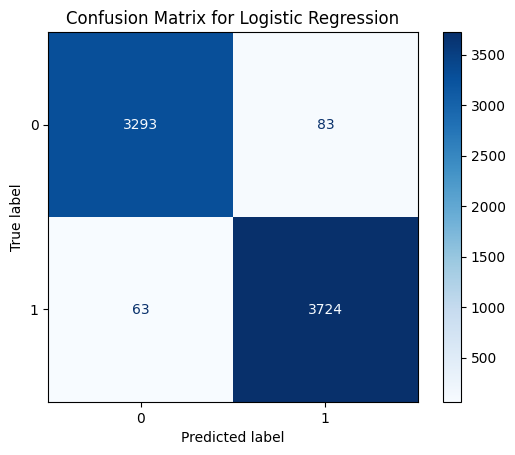

Model: Random Forest
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3376
           1       0.98      1.00      0.99      3787

    accuracy                           0.99      7163
   macro avg       0.99      0.99      0.99      7163
weighted avg       0.99      0.99      0.99      7163



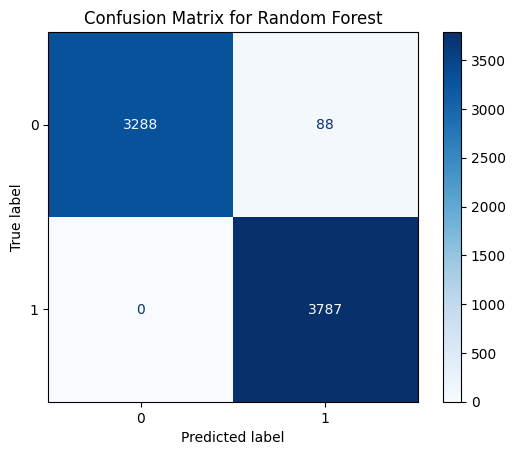

Model: Support Vector Classifier
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3376
           1       0.99      0.99      0.99      3787

    accuracy                           0.99      7163
   macro avg       0.99      0.99      0.99      7163
weighted avg       0.99      0.99      0.99      7163



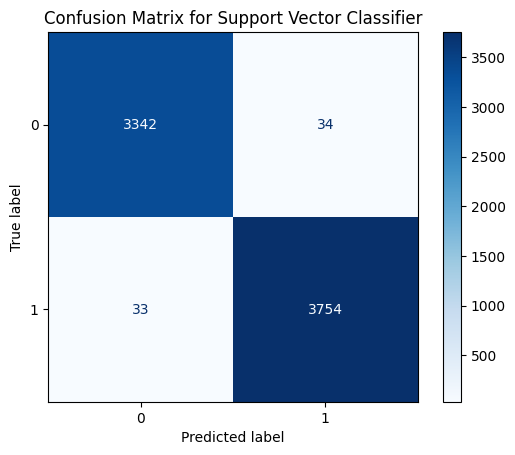

Model: Decision Tree
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.93      3376
           1       0.91      0.98      0.94      3787

    accuracy                           0.93      7163
   macro avg       0.94      0.93      0.93      7163
weighted avg       0.94      0.93      0.93      7163



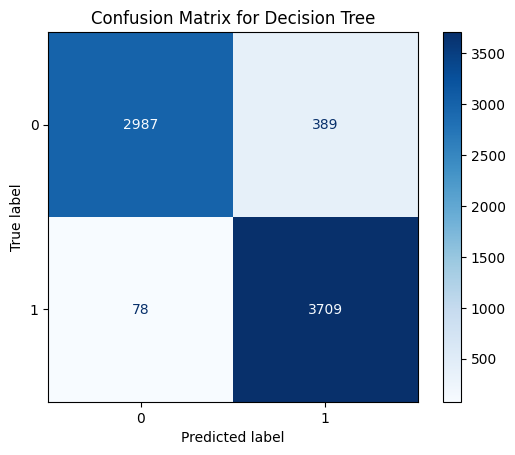

Model: K-Nearest Neighbors
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3376
           1       0.96      0.98      0.97      3787

    accuracy                           0.97      7163
   macro avg       0.97      0.97      0.97      7163
weighted avg       0.97      0.97      0.97      7163



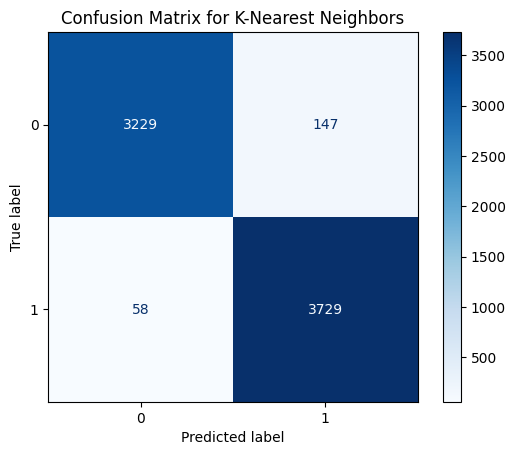

Model: Naive Bayes
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      3376
           1       1.00      0.71      0.83      3787

    accuracy                           0.85      7163
   macro avg       0.88      0.85      0.85      7163
weighted avg       0.88      0.85      0.84      7163



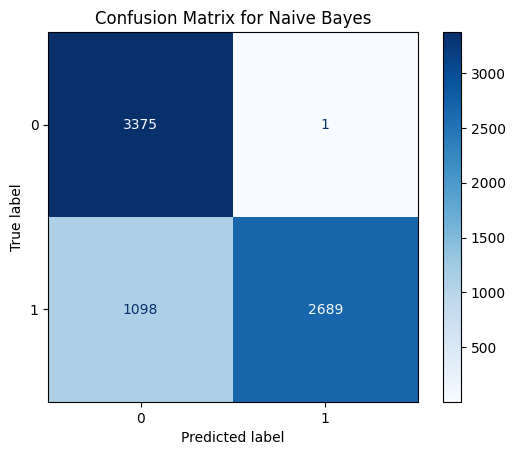

Model: Gradient Boosting
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3376
           1       0.92      0.98      0.95      3787

    accuracy                           0.94      7163
   macro avg       0.95      0.94      0.94      7163
weighted avg       0.95      0.94      0.94      7163



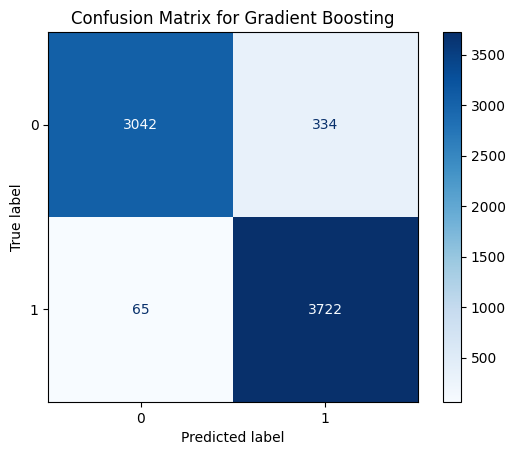

Model: AdaBoost
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3376
           1       0.97      1.00      0.98      3787

    accuracy                           0.98      7163
   macro avg       0.98      0.98      0.98      7163
weighted avg       0.98      0.98      0.98      7163



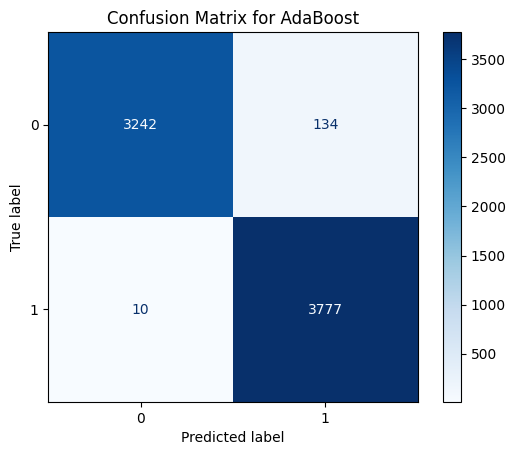

Model: Ridge Classifier
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3376
           1       1.00      0.96      0.98      3787

    accuracy                           0.98      7163
   macro avg       0.98      0.98      0.98      7163
weighted avg       0.98      0.98      0.98      7163



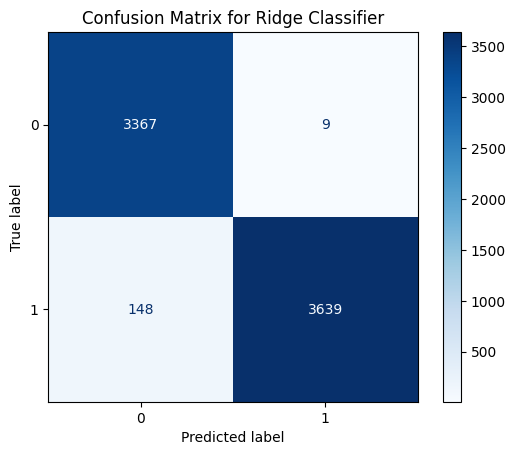

Model: XGBoost
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3376
           1       0.91      0.98      0.95      3787

    accuracy                           0.94      7163
   macro avg       0.95      0.94      0.94      7163
weighted avg       0.95      0.94      0.94      7163



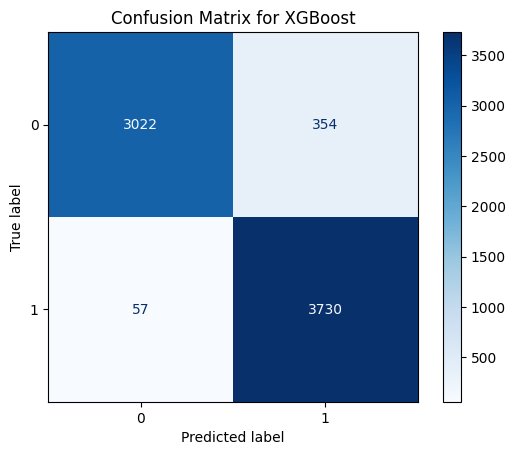

In [25]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Ridge Classifier": RidgeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}
def train_and_evaluate_models(x_train, y_train, x_test, y_test):
    for model_name, model in classifiers.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        # Display results
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy:.2f}")
        report = classification_report(y_test, y_pred)
        print("Classification Report:")
        print(report)
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

# Run the function to train and evaluate all models
train_and_evaluate_models(x_train_scaled, y_train, x_test_scaled, y_test)

Model: Stacking Model
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3376
           1       0.99      1.00      1.00      3787

    accuracy                           0.99      7163
   macro avg       1.00      0.99      0.99      7163
weighted avg       1.00      0.99      0.99      7163



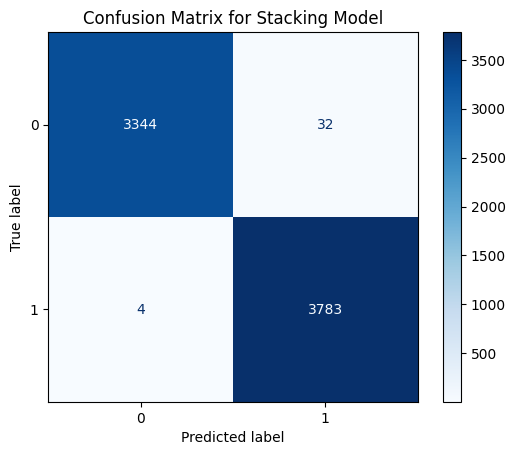

In [26]:
# Define the base classifiers (using Random Forest and others)
base_classifiers = [
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('adaboost', AdaBoostClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, kernel='linear', random_state=42)),
    ('decision_tree', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('gradient_boost', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Define the meta-classifier as XGBoost
meta_classifier = XGBClassifier(n_estimators=500, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    
# Create the StackingClassifier
stacking_clf = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=meta_classifier,
        cv=5,  # Cross-validation for better generalization
        stack_method='predict_proba',  # Use probabilities as input to meta-classifier
        passthrough=True,
    )
    
# Train the stacking model
stacking_clf.fit(x_train_scaled, y_train)
    
# Evaluate on the test set
y_pred = stacking_clf.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
    
# Display model performance
model_name = "Stacking Model"
print(f"Model: {model_name}")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)
    
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {model_name}')
plt.show()